# Testing Llama 3.2 3B on Detection/Sanitization of poisoned data

In [1]:
# Title: Testing Llama 3.2 3B on MotionSense Data and Evaluating Poisoning Detection
# Install dependencies
%%capture
!pip install unsloth pandas numpy scikit-learn matplotlib seaborn datasets transformers trl torch accelerate
# Get the latest nightly Unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import necessary libraries
import unsloth
from unsloth import FastLanguageModel
from google.colab import drive
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import TrainingArguments, DataCollatorForSeq2Seq, pipeline
from trl import SFTTrainer
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
import json
import numpy as np

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
# 1. Mount Google Drive
drive.mount('/content/drive')
HOME = '/content/drive/MyDrive'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 3. Paths and parameters
CSV_PATH = os.path.join(HOME, 'combined_motionsense.csv')
POISONED_PATH = os.path.join(HOME, 'poisoned.csv')
GROUND_TRUTH_PATH = os.path.join(HOME, 'ground_truth.csv')
OUTPUT_DIR = os.path.join(HOME, 'llama3.2_finetuned')
REPORT_JSON = os.path.join(HOME, 'llama3.2-3b_finetuned_eval_report.json')

MAX_SEQ_LENGTH = 2048
SAMPLE_SIZE = 1500
BATCH_SIZE = 2
LR = 2e-4
EPOCHS = 3
SEED = 42

sensor_cols = [
    'attitude.roll','attitude.pitch','attitude.yaw',
    'gravity.x','gravity.y','gravity.z',
    'rotationRate.x','rotationRate.y','rotationRate.z',
    'userAcceleration.x','userAcceleration.y','userAcceleration.z'
]
LABEL_COL = 'Label'

In [12]:
# 4. Load and sample data
df = pd.read_csv(CSV_PATH)
train_df = df.sample(n=SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)

# Load poisoned dataset and ground truth for evaluation
poisoned_df = pd.read_csv(POISONED_PATH)
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)

# Merge to get poisoning information
eval_df = poisoned_df.merge(ground_truth_df, left_index=True, right_index=True, suffixes=('_poisoned', '_true'))
eval_df['is_poisoned'] = eval_df['Label_poisoned'] != eval_df['Label_true']

print(f"Training data shape: {train_df.shape}")
print(f"Evaluation data shape: {eval_df.shape}")
print(f"Number of poisoned samples: {eval_df['is_poisoned'].sum()}")

Training data shape: (1500, 14)
Evaluation data shape: (400, 31)
Number of poisoned samples: 160


In [7]:
# Format prompts
def format_prompt(row, few_shot_examples=None):
    prompt = ''
    if few_shot_examples:
        for ex_text, ex_label in few_shot_examples:
            prompt += ex_text + f" {ex_label}\n---\n"
    features = ", ".join([f"{c}: {row[c]}" for c in sensor_cols])
    return prompt + f"Sensor readings: {features}\nActivity:"

train_df['text'] = train_df.apply(lambda r: format_prompt(r), axis=1)
train_df['label_text'] = train_df[LABEL_COL]


In [8]:

# 5. Initialize model - Updated with proper device settings
# Check if CUDA is available and set device appropriately
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set dtype properly based on hardware
if torch.cuda.is_available():
    dtype = torch.float16
    load_in_4bit = True if torch.cuda.get_device_properties(0).total_memory > 16e9 else False
    print(f"Using dtype: {dtype}, 4bit: {load_in_4bit}")
else:
    dtype = None
    load_in_4bit = False
    print("Using CPU, so dtype is None and not using 4bit")

# Load the model with explicit device placement
model_name = 'unsloth/Llama-3.2-3B'
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    device_map="auto"  # This helps with proper device placement
)

# Update the model with LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    use_gradient_checkpointing="unsloth",
    bias="none"  # Explicitly set bias to avoid certain issues
)

# Make sure tokenizer has pad_token set correctly
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Using device: cuda
Using dtype: torch.float16, 4bit: False
==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

Unsloth 2025.5.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [9]:

# 6. Prepare HF dataset
# Format prompts - update this function to be clearer
def format_prompt(row):
    features = ", ".join([f"{c}: {row[c]}" for c in sensor_cols])
    return f"Sensor readings: {features}\nActivity:"

def format_training_sample(row):
    # Input text - what the model sees
    input_text = format_prompt(row)
    # Output text - what the model should generate
    output_text = row[LABEL_COL]
    return {
        "input": input_text,
        "output": output_text
    }

# Apply the formatting to create input/output pairs
formatted_data = []
for _, row in train_df.iterrows():
    formatted_data.append(format_training_sample(row))

# Create a new Dataset with proper format for instruction tuning
train_dataset = Dataset.from_list(formatted_data)

# The SFTTrainer requires specific formatting
def formatting_func(examples):
    texts = []
    for i in range(len(examples["input"])):
        # Format as: <s>Input Output</s>
        # The input already ends with "Activity:", so just append the label
        text = f"<s>{examples['input'][i]} {examples['output'][i]}</s>"
        texts.append(text)
    return {"text": texts}

# Apply the formatting
train_dataset = train_dataset.map(formatting_func, batched=True, remove_columns=train_dataset.column_names)

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

--- Starting Base Model Evaluation ---
Using the base model loaded in memory.
Running zero-shot detection with base model...
Processed batch 1/80
Cleared CUDA cache.
Processed batch 2/80
Cleared CUDA cache.
Processed batch 3/80
Cleared CUDA cache.
Processed batch 4/80
Cleared CUDA cache.
Processed batch 5/80
Cleared CUDA cache.
Processed batch 6/80
Cleared CUDA cache.
Processed batch 7/80
Cleared CUDA cache.
Processed batch 8/80
Cleared CUDA cache.
Processed batch 9/80
Cleared CUDA cache.
Processed batch 10/80
Cleared CUDA cache.
Processed batch 11/80
Cleared CUDA cache.
Processed batch 12/80
Cleared CUDA cache.
Processed batch 13/80
Cleared CUDA cache.
Processed batch 14/80
Cleared CUDA cache.
Processed batch 15/80
Cleared CUDA cache.
Processed batch 16/80
Cleared CUDA cache.
Processed batch 17/80
Cleared CUDA cache.
Processed batch 18/80
Cleared CUDA cache.
Processed batch 19/80
Cleared CUDA cache.
Processed batch 20/80
Cleared CUDA cache.
Processed batch 21/80
Cleared CUDA cache.
Pr

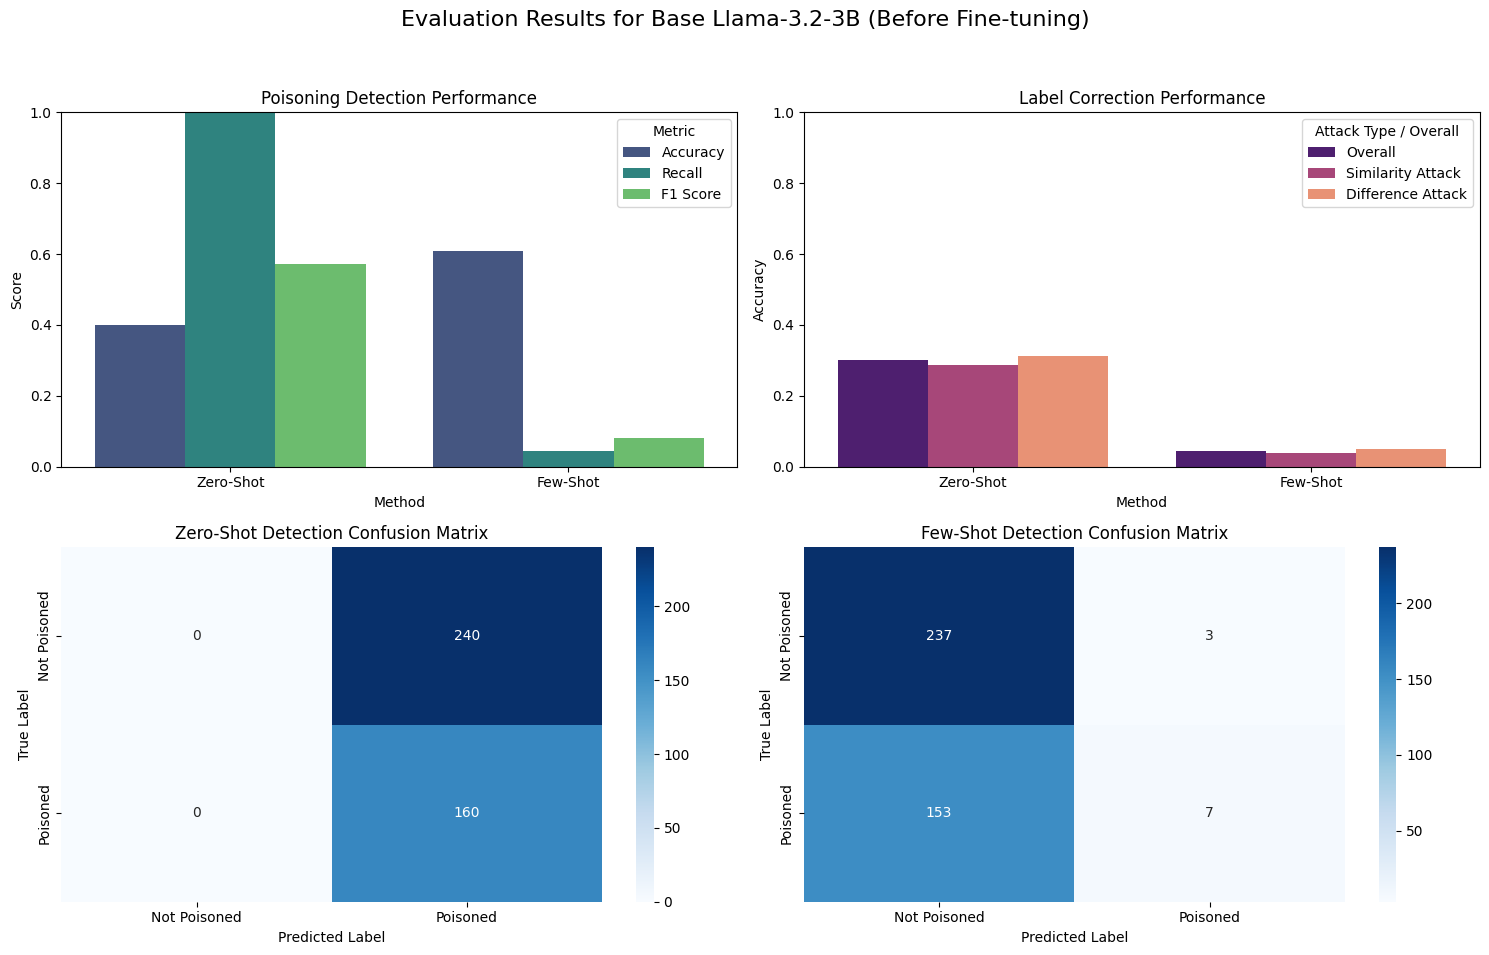

--- Finished Base Model Evaluation ---


In [17]:
# Evaluating Base Model Before Fine-Tuning

import torch
import gc
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os

print("--- Starting Base Model Evaluation ---")

# Use the already loaded model and tokenizer from previous cells
base_model = model
base_tokenizer = tokenizer
print("Using the base model loaded in memory.")

# Ensure pad token is set
if base_tokenizer.pad_token is None:
    base_tokenizer.pad_token = base_tokenizer.eos_token
    base_tokenizer.pad_token_id = base_tokenizer.eos_token_id

# Helper to clear CUDA cache
def clear_cuda_cache():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        print("Cleared CUDA cache.")

# Generate response function
def generate_response(model, tokenizer, prompt):
    """Generate a response from the model for a given prompt"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_length = inputs.input_ids.shape[1]

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=20,
            temperature=0.1,
            top_p=0.95,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode only the newly generated tokens
    new_tokens = outputs[0, input_length:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    # Basic cleanup: Take the first word/token as the likely answer
    response_parts = response.split()
    cleaned_response = response_parts[0] if response_parts else ""
    cleaned_response = cleaned_response.replace(".", "").replace(",", "").replace(":", "")

    return cleaned_response

# Process responses
def process_poisoning_response(response):
    response = response.lower()
    if 'yes' in response:
        return True
    elif 'no' in response:
        return False
    else:
        print(f"Warning: Unclear poison response '{response}', defaulting to False")
        return False

def process_sanitize_response(response):
    response = response.lower().strip()
    valid_labels = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

    if response in valid_labels:
        return response
    else:
        print(f"Warning: Unclear sanitize response '{response}', defaulting to 'unknown'")
        return "unknown"

# Process in batches
def process_in_batches(df, prompt_func, process_func, batch_size=5):
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_prompts = [prompt_func(row) for _, row in batch.iterrows()]
        batch_responses = [generate_response(base_model, base_tokenizer, prompt) for prompt in batch_prompts]
        batch_results = [process_func(response) for response in batch_responses]
        results.extend(batch_results)
        print(f"Processed batch {i//batch_size + 1}/{total_batches}")
        clear_cuda_cache()
    return results

# Run zero-shot detection
print("Running zero-shot detection with base model...")
eval_df['is_poisoned_zero_shot_base'] = process_in_batches(
    eval_df,
    format_zero_shot_prompt,
    process_poisoning_response,
    batch_size=5
)

# Run few-shot detection
print("Running few-shot detection with base model...")
eval_df['is_poisoned_few_shot_base'] = process_in_batches(
    eval_df,
    format_few_shot_prompt,
    process_poisoning_response,
    batch_size=5
)

# Save intermediate results
eval_df.to_csv(os.path.join(HOME, 'eval_with_detection_base.csv'), index=False)
print("Detection results saved!")

# Run sanitization for detected poisoned samples
zero_shot_poisoned_df = eval_df[eval_df['is_poisoned_zero_shot_base']].copy()
few_shot_poisoned_df = eval_df[eval_df['is_poisoned_few_shot_base']].copy()

# Zero-shot sanitization
print("Running zero-shot sanitization with base model...")
if not zero_shot_poisoned_df.empty:
    zero_shot_poisoned_df['corrected_label_zero_shot_base'] = process_in_batches(
        zero_shot_poisoned_df,
        format_zero_shot_sanitize_prompt,
        process_sanitize_response,
        batch_size=5
    )
    eval_df = eval_df.merge(
        zero_shot_poisoned_df[['corrected_label_zero_shot_base']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by zero-shot method.")
    eval_df['corrected_label_zero_shot_base'] = np.nan

# Few-shot sanitization
print("Running few-shot sanitization with base model...")
if not few_shot_poisoned_df.empty:
    few_shot_poisoned_df['corrected_label_few_shot_base'] = process_in_batches(
        few_shot_poisoned_df,
        format_few_shot_sanitize_prompt,
        process_sanitize_response,
        batch_size=5
    )
    eval_df = eval_df.merge(
        few_shot_poisoned_df[['corrected_label_few_shot_base']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by few-shot method.")
    eval_df['corrected_label_few_shot_base'] = np.nan

# Fill NaN values
eval_df['corrected_label_zero_shot_base'] = eval_df['corrected_label_zero_shot_base'].fillna(eval_df['Label_poisoned'])
eval_df['corrected_label_few_shot_base'] = eval_df['corrected_label_few_shot_base'].fillna(eval_df['Label_poisoned'])

# Handle 'unknown' responses
eval_df['corrected_label_zero_shot_base'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_zero_shot_base'] == 'unknown' else row['corrected_label_zero_shot_base'],
    axis=1
)
eval_df['corrected_label_few_shot_base'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_few_shot_base'] == 'unknown' else row['corrected_label_few_shot_base'],
    axis=1
)

print("Sanitization complete!")

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'true_positives': int(tp),
        'false_positives': int(fp),
        'true_negatives': int(tn),
        'false_negatives': int(fn)
    }

def evaluate_correction(df, corrected_col):
    poisoned_df = df[df['is_poisoned']].copy()
    poisoned_df['correction_correct'] = poisoned_df[corrected_col] == poisoned_df['Label_true']
    correction_accuracy = poisoned_df['correction_correct'].mean()

    # Define similar activity pairs
    similar_pairs = [
        {'walking', 'jogging'},
        {'walking', 'upstairs'},
        {'walking', 'downstairs'},
        {'jogging', 'upstairs'},
        {'jogging', 'downstairs'},
        {'upstairs', 'downstairs'},
        {'sitting', 'standing'}
    ]

    poisoned_df['attack_type'] = 'unknown'
    for idx, row in poisoned_df.iterrows():
        true_label = row['Label_true']
        poisoned_label = row['Label_poisoned']

        is_similarity_attack = False
        for pair in similar_pairs:
            if true_label in pair and poisoned_label in pair:
                is_similarity_attack = True
                break

        poisoned_df.at[idx, 'attack_type'] = 'similarity' if is_similarity_attack else 'difference'

    similarity_accuracy = poisoned_df[poisoned_df['attack_type'] == 'similarity']['correction_correct'].mean()
    difference_accuracy = poisoned_df[poisoned_df['attack_type'] == 'difference']['correction_correct'].mean()

    similarity_corrected = poisoned_df[(poisoned_df['attack_type'] == 'similarity') & poisoned_df['correction_correct']].shape[0]
    similarity_total = poisoned_df[poisoned_df['attack_type'] == 'similarity'].shape[0]
    difference_corrected = poisoned_df[(poisoned_df['attack_type'] == 'difference') & poisoned_df['correction_correct']].shape[0]
    difference_total = poisoned_df[poisoned_df['attack_type'] == 'difference'].shape[0]

    return {
        'correction_accuracy': correction_accuracy,
        'similarity_attack_accuracy': similarity_accuracy,
        'difference_attack_accuracy': difference_accuracy,
        'similarity_corrected': similarity_corrected,
        'similarity_total': similarity_total,
        'difference_corrected': difference_corrected,
        'difference_total': difference_total
    }

# Evaluate detection performance
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_base']
)

few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_base']
)

print("Zero-shot detection metrics:")
print(zero_shot_metrics)
print("\nFew-shot detection metrics:")
print(few_shot_metrics)

# Evaluate correction performance
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_base')
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_base')

print("Zero-shot correction metrics:")
print(zero_shot_correction_metrics)
print("\nFew-shot correction metrics:")
print(few_shot_correction_metrics)

# Convert NumPy types for JSON serialization
def convert_np_types(obj):
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                        np.int16, np.int32, np.int64, np.uint8,
                        np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float16, np.float32, np.float64)):
        if np.isnan(obj):
            return None
        elif np.isinf(obj):
            return None
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_np_types(i) for i in obj]
    return obj

# Create evaluation report
evaluation_report = {
    'model_name': 'unsloth/Llama-3.2-3B-base (Before Fine-tuning)',
    'detection': {
        'zero_shot': zero_shot_metrics,
        'few_shot': few_shot_metrics
    },
    'correction': {
        'zero_shot': zero_shot_correction_metrics,
        'few_shot': few_shot_correction_metrics
    },
    'dataset_info': {
        'total_samples': len(eval_df),
        'poisoned_samples': int(eval_df['is_poisoned'].sum()),
        'poisoning_rate': float(eval_df['is_poisoned'].mean())
    }
}

evaluation_report = convert_np_types(evaluation_report)

# Save the report
REPORT_JSON_BASE = os.path.join(HOME, 'llama3.2-3b-base_before_finetuning_eval_report.json')
with open(REPORT_JSON_BASE, 'w') as f:
    json.dump(evaluation_report, f, indent=4)
print(f"Evaluation report saved to {REPORT_JSON_BASE}")

# Display the report
print("\n--- Evaluation Report ---")
print(json.dumps(evaluation_report, indent=4))
print("--- End Report ---")

# Visualize results
plt.figure(figsize=(15, 10))
plt.suptitle('Evaluation Results for Base Llama-3.2-3B (Before Fine-tuning)', fontsize=16)

# Detection Performance
plt.subplot(2, 2, 1)
detection_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Accuracy': [evaluation_report['detection']['zero_shot']['accuracy'], evaluation_report['detection']['few_shot']['accuracy']],
    'Recall': [evaluation_report['detection']['zero_shot']['recall'], evaluation_report['detection']['few_shot']['recall']],
    'F1 Score': [evaluation_report['detection']['zero_shot']['f1_score'], evaluation_report['detection']['few_shot']['f1_score']]
}
detection_df = pd.DataFrame(detection_data)
detection_df_melted = pd.melt(detection_df, id_vars=['Method'], var_name='Metric', value_name='Score')
sns.barplot(x='Method', y='Score', hue='Metric', data=detection_df_melted, palette='viridis')
plt.title('Poisoning Detection Performance')
plt.ylim(0, 1)
plt.ylabel('Score')

# Correction Performance
plt.subplot(2, 2, 2)
correction_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Overall': [evaluation_report['correction']['zero_shot'].get('correction_accuracy', 0), evaluation_report['correction']['few_shot'].get('correction_accuracy', 0)],
    'Similarity Attack': [evaluation_report['correction']['zero_shot'].get('similarity_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('similarity_attack_accuracy', 0)],
    'Difference Attack': [evaluation_report['correction']['zero_shot'].get('difference_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('difference_attack_accuracy', 0)]
}
correction_df = pd.DataFrame(correction_data)
correction_df_melted = pd.melt(correction_df, id_vars=['Method'], var_name='Attack Type / Overall', value_name='Accuracy')
sns.barplot(x='Method', y='Accuracy', hue='Attack Type / Overall', data=correction_df_melted, palette='magma')
plt.title('Label Correction Performance')
plt.ylim(0, 1)
plt.ylabel('Accuracy')

# Confusion matrices
plt.subplot(2, 2, 3)
cm_zero = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_zero_shot_base'])
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'])
plt.title('Zero-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.subplot(2, 2, 4)
cm_few = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_few_shot_base'])
sns.heatmap(cm_few, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'])
plt.title('Few-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
PLOT_FILENAME_BASE = os.path.join(HOME, 'llama3.2-base_before_finetuning_evaluation.png')
plt.savefig(PLOT_FILENAME_BASE, dpi=300)
print(f"Evaluation plot saved to {PLOT_FILENAME_BASE}")
plt.show()

print("--- Finished Base Model Evaluation ---")

In [ ]:
# Evaluating Model Before Fine-Tuning

import unsloth
from unsloth import FastLanguageModel
import torch
import gc # Garbage collector

print("--- Starting Enhanced Debugging Cell ---")

# --- Configuration ---
BASE_MODEL_NAME = 'unsloth/Llama-3.2-3B' # Or your original base model name
MAX_SEQ_LENGTH = 2048 # Ensure this matches your settings

# --- Ensure Fine-tuned Model is Loaded ---
if 'ft_model' not in locals() or 'ft_tokenizer' not in locals():
    print("Error: Fine-tuned model (ft_model) or tokenizer (ft_tokenizer) not found.")
    print("Please ensure the training cell has run successfully.")
    # Optionally add code here to load it if needed, e.g.:
    # ft_model, ft_tokenizer = FastLanguageModel.from_pretrained(OUTPUT_DIR, ...)
    ft_model_loaded = False
else:
    print(f"Found fine-tuned model: {ft_model.config._name_or_path}")
    print(f"Found fine-tuned tokenizer: {ft_tokenizer.name_or_path}")
    ft_model_loaded = True

# --- Load Base Model (if not already loaded) ---
if 'base_model' not in locals() or 'base_tokenizer' not in locals():
    print(f"Loading base model: {BASE_MODEL_NAME}...")
    try:
        # Determine dtype and load_in_4bit based on availability
        if torch.cuda.is_available():
            dtype = torch.float16
            load_in_4bit = True if torch.cuda.get_device_properties(0).total_memory > 16e9 else False
            print(f"Base model: Using dtype: {dtype}, 4bit: {load_in_4bit}")
        else:
            dtype = None
            load_in_4bit = False
            print("Base model: Using CPU, so dtype is None and not using 4bit")

        base_model, base_tokenizer = FastLanguageModel.from_pretrained(
            model_name=BASE_MODEL_NAME,
            max_seq_length=MAX_SEQ_LENGTH,
            dtype=dtype,
            load_in_4bit=load_in_4bit,
            device_map="auto"
        )
        if base_tokenizer.pad_token is None:
             base_tokenizer.pad_token = base_tokenizer.eos_token
        print("Base model loaded successfully.")
        base_model_loaded = True
    except Exception as e:
        print(f"Error loading base model: {e}")
        base_model_loaded = False
else:
    print("Base model already loaded.")
    base_model_loaded = True

# --- Define Simplified Prompt Function ---
def format_zero_shot_prompt_simplified(row):
    """Simpler prompt potentially for the fine-tuned model"""
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Very direct question, less context
    prompt = f"""[INST]Sensor readings: {features}
Provided label: {row['Label_poisoned']}
Is the label correct for the readings? (Yes/No)[/INST]"""
    return prompt

# --- Helper to clear CUDA cache ---
def clear_cuda_cache():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        print("Cleared CUDA cache.")

# --- Select Samples and Run Debugging ---
if ft_model_loaded and base_model_loaded:
    # Select indices (same logic as before)
    debug_indices = []
    try:
        poisoned_idx = eval_df[eval_df['is_poisoned']].index[0]
        debug_indices.append(poisoned_idx)
    except IndexError: pass
    try:
        clean_idx = eval_df[~eval_df['is_poisoned']].index[0]
        if clean_idx not in debug_indices: debug_indices.append(clean_idx)
    except IndexError: pass
    if not debug_indices and len(eval_df) > 0: debug_indices.append(eval_df.index[0]) # Fallback

    if not debug_indices:
        print("Error: No samples found in eval_df to debug.")
    else:
        print(f"Will debug samples with original indices: {debug_indices}")

        # --- Debugging Loop ---
        for idx in debug_indices:
            if idx not in eval_df.index:
                print(f"\nError: Index {idx} not found in eval_df. Skipping.")
                continue

            sample_row = eval_df.loc[idx]
            ground_truth_poisoned = sample_row['is_poisoned']
            # Note: Simplified prompt asks "correct?", so expected answer is inverted
            ground_truth_simplified = not ground_truth_poisoned

            print(f"\n\n=== Debugging Sample Index: {idx} ===")
            print(f"Ground Truth: {'Poisoned' if ground_truth_poisoned else 'Not Poisoned'} (Label is {'INCORRECT' if ground_truth_poisoned else 'CORRECT'})")
            print(f"Poisoned Label Provided: {sample_row['Label_poisoned']}")
            print(f"True Label: {sample_row['Label_true']}")
            print("=" * 30)

            # --- Test 1: Fine-tuned Model + Original Prompt ---
            print("\n>>> Test 1: Fine-tuned Model + Original Prompt (EXPECTED TO FAIL)")
            clear_cuda_cache() # Clear cache before generation
            zero_shot_prompt_orig = format_zero_shot_prompt(sample_row)
            try:
                raw_resp_ft_orig = generate_response(ft_model, ft_tokenizer, zero_shot_prompt_orig)
                print(f"Raw Response:\n```\n{raw_resp_ft_orig}\n```")
                parsed_resp_ft_orig = process_poisoning_response(raw_resp_ft_orig)
                print(f"Parsed Result (True=Poisoned): {parsed_resp_ft_orig}")
                print(f"Matches Ground Truth: {parsed_resp_ft_orig == ground_truth_poisoned}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

            # --- Test 2: Fine-tuned Model + Simplified Prompt ---
            print("\n>>> Test 2: Fine-tuned Model + Simplified Prompt")
            clear_cuda_cache()
            zero_shot_prompt_simp = format_zero_shot_prompt_simplified(sample_row)
            print(f"Simplified Prompt:\n```\n{zero_shot_prompt_simp}\n```")
            try:
                raw_resp_ft_simp = generate_response(ft_model, ft_tokenizer, zero_shot_prompt_simp)
                print(f"Raw Response:\n```\n{raw_resp_ft_simp}\n```")
                # We still use the same parser, looking for 'yes'/'no'
                parsed_resp_ft_simp = process_poisoning_response(raw_resp_ft_simp)
                print(f"Parsed Result (True=Yes): {parsed_resp_ft_simp}")
                # Compare to inverted ground truth because prompt asks "Is it correct?"
                print(f"Matches Expected Answer ('{'Yes' if ground_truth_simplified else 'No'}'): {parsed_resp_ft_simp == ground_truth_simplified}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

            # --- Test 3: Base Model + Original Prompt ---
            print("\n>>> Test 3: Base Model + Original Prompt (EXPECTED TO WORK BETTER)")
            clear_cuda_cache()
            # Use the original zero-shot prompt with the base model
            try:
                raw_resp_base_orig = generate_response(base_model, base_tokenizer, zero_shot_prompt_orig)
                print(f"Raw Response:\n```\n{raw_resp_base_orig}\n```")
                parsed_resp_base_orig = process_poisoning_response(raw_resp_base_orig)
                print(f"Parsed Result (True=Poisoned): {parsed_resp_base_orig}")
                print(f"Matches Ground Truth: {parsed_resp_base_orig == ground_truth_poisoned}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

        # --- Clean up base model if memory is tight ---
        # del base_model
        # del base_tokenizer
        # clear_cuda_cache()
        # print("Base model removed from memory.")

else:
    print("Debugging skipped because models were not loaded correctly.")


print("--- Finished Enhanced Debugging Cell ---")


# Cell 11: Run zero-shot and few-shot detection with the fine-tuned base model

def generate_response(model, tokenizer, prompt):
    """Generate a response from the model for a given prompt (Base Model Handling)"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_length = inputs.input_ids.shape[1] # Get length of the prompt tokens

    # Ensure the tokenizer has a pad token defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    with torch.no_grad():
        # Generate outputs, ensuring pad_token_id is set for base models
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask, # Include attention mask
            max_new_tokens=20, # Keep enough tokens for the answer (Yes/No or label)
            temperature=0.1,   # Low temperature for deterministic output
            top_p=0.95,
            do_sample=False,   # Disable sampling for more predictable output
            pad_token_id=tokenizer.eos_token_id # Crucial for base model generation
        )

    # Decode only the newly generated tokens, skipping the prompt
    new_tokens = outputs[0, input_length:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    # Basic cleanup: Take the first word/token as the likely answer
    response_parts = response.split()
    cleaned_response = response_parts[0] if response_parts else ""
    # Remove common punctuation that might stick
    cleaned_response = cleaned_response.replace(".", "").replace(",", "").replace(":", "")

    # print(f"Prompt: '{prompt[-100:]}'\nRaw Response: '{response}'\nCleaned Response: '{cleaned_response}'") # Debugging

    return cleaned_response

# Use the fine-tuned model already in memory
ft_model = model
ft_tokenizer = tokenizer
print("Using the fine-tuned base model loaded in memory.")


# Process a batch of rows to avoid memory issues
def process_in_batches(df, prompt_func, process_func, batch_size=10):
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_prompts = [prompt_func(row) for _, row in batch.iterrows()]
        # Use the updated generate_response function
        batch_responses = [generate_response(ft_model, ft_tokenizer, prompt) for prompt in batch_prompts]
        batch_results = [process_func(response) for response in batch_responses]
        results.extend(batch_results)
        print(f"Processed batch {i//batch_size + 1}/{total_batches}")
        # Optional: Clear CUDA cache periodically if memory issues persist
        # if torch.cuda.is_available():
        #     torch.cuda.empty_cache()
    return results

# Process the response for poisoning detection
def process_poisoning_response(response):
    response = response.lower()
    if 'yes' in response:
        return True
    elif 'no' in response:
        return False
    else:
        # Default to False if response is unclear
        print(f"Warning: Unclear poison response '{response}', defaulting to False") # Add logging
        return False

# Run zero-shot detection
print("Running zero-shot detection with fine-tuned base model...")
eval_df['is_poisoned_zero_shot_ft'] = process_in_batches(
    eval_df,
    format_zero_shot_prompt, # Uses updated prompt function
    process_poisoning_response,
    batch_size=5 # Smaller batch size might be needed for base models
)

# Run few-shot detection
print("Running few-shot detection with fine-tuned base model...")
eval_df['is_poisoned_few_shot_ft'] = process_in_batches(
    eval_df,
    format_few_shot_prompt, # Uses updated prompt function
    process_poisoning_response,
    batch_size=5 # Smaller batch size might be needed for base models
)

# Save intermediate results
eval_df.to_csv(os.path.join(HOME, 'eval_with_detection_ft_base.csv'), index=False) # Changed filename
print("Detection results saved!")

# Cell 12: Run sanitization (label correction) for detected poisoned samples with Base Model

# Process the response for label sanitization
def process_sanitize_response(response):
    response = response.lower().strip()
    valid_labels = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

    # Check if the cleaned response *is* one of the valid labels
    if response in valid_labels:
        return response
    else:
        # If no valid label is found directly, return unknown
        print(f"Warning: Unclear sanitize response '{response}', defaulting to 'unknown'") # Add logging
        return "unknown" # Or return the original poisoned label? Depends on desired behavior

# Create dataframes for zero-shot and few-shot sanitization
# Ensure the detection columns exist before filtering
if 'is_poisoned_zero_shot_ft' not in eval_df.columns:
     raise KeyError("Column 'is_poisoned_zero_shot_ft' not found. Ensure detection ran successfully.")
if 'is_poisoned_few_shot_ft' not in eval_df.columns:
     raise KeyError("Column 'is_poisoned_few_shot_ft' not found. Ensure detection ran successfully.")

zero_shot_poisoned_df = eval_df[eval_df['is_poisoned_zero_shot_ft']].copy()
few_shot_poisoned_df = eval_df[eval_df['is_poisoned_few_shot_ft']].copy()

# Run zero-shot sanitization only if there are samples detected
print("Running zero-shot sanitization with fine-tuned base model...")
if not zero_shot_poisoned_df.empty:
    zero_shot_poisoned_df['corrected_label_zero_shot_ft'] = process_in_batches(
        zero_shot_poisoned_df,
        format_zero_shot_sanitize_prompt, # Uses updated prompt function
        process_sanitize_response,
        batch_size=5 # Smaller batch size
    )
    # Merge the sanitized labels back into the main dataframe
    eval_df = eval_df.merge(
        zero_shot_poisoned_df[['corrected_label_zero_shot_ft']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by zero-shot method. Skipping sanitization.")
    eval_df['corrected_label_zero_shot_ft'] = np.nan # Add column with NaNs

# Run few-shot sanitization only if there are samples detected
print("Running few-shot sanitization with fine-tuned base model...")
if not few_shot_poisoned_df.empty:
    few_shot_poisoned_df['corrected_label_few_shot_ft'] = process_in_batches(
        few_shot_poisoned_df,
        format_few_shot_sanitize_prompt, # Uses updated prompt function
        process_sanitize_response,
        batch_size=5 # Smaller batch size
    )
    # Merge the sanitized labels back into the main dataframe
    eval_df = eval_df.merge(
        few_shot_poisoned_df[['corrected_label_few_shot_ft']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by few-shot method. Skipping sanitization.")
    eval_df['corrected_label_few_shot_ft'] = np.nan # Add column with NaNs


# Fill NaN values for samples that weren't detected as poisoned or where sanitization failed
# Use the original *poisoned* label as fallback if correction wasn't attempted/successful
eval_df['corrected_label_zero_shot_ft'] = eval_df['corrected_label_zero_shot_ft'].fillna(eval_df['Label_poisoned'])
eval_df['corrected_label_few_shot_ft'] = eval_df['corrected_label_few_shot_ft'].fillna(eval_df['Label_poisoned'])

# Handle cases where sanitization returned 'unknown' - revert to poisoned label
eval_df['corrected_label_zero_shot_ft'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_zero_shot_ft'] == 'unknown' else row['corrected_label_zero_shot_ft'],
    axis=1
)
eval_df['corrected_label_few_shot_ft'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_few_shot_ft'] == 'unknown' else row['corrected_label_few_shot_ft'],
    axis=1
)


# Save sanitized datasets
sanitized_zero_shot_ft = eval_df.copy()
# Use the corrected label column for the final 'Label'
sanitized_zero_shot_ft['Label'] = sanitized_zero_shot_ft['corrected_label_zero_shot_ft']
sanitized_zero_shot_ft.to_csv(os.path.join(HOME, 'sanitized_zero_shot_ft_base.csv'), index=False)

sanitized_few_shot_ft = eval_df.copy()
# Use the corrected label column for the final 'Label'
sanitized_few_shot_ft['Label'] = sanitized_few_shot_ft['corrected_label_few_shot_ft']
sanitized_few_shot_ft.to_csv(os.path.join(HOME, 'sanitized_few_shot_ft_base.csv'), index=False)

print("Sanitization complete and results saved!")

# 13. Evaluate detection performance

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score"""
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate true/false positives/negatives
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'true_positives': int(tp),
        'false_positives': int(fp),
        'true_negatives': int(tn),
        'false_negatives': int(fn)
    }

# Evaluate zero-shot detection
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_ft']
)

# Evaluate few-shot detection
few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_ft']
)

print("Zero-shot detection metrics:")
print(zero_shot_metrics)
print("\nFew-shot detection metrics:")
print(few_shot_metrics)

# 14. Evaluate label correction performance

def evaluate_correction(df, corrected_col):
    """Evaluate the performance of label correction"""
    # Only consider rows that were actually poisoned
    poisoned_df = df[df['is_poisoned']].copy()

    # Check if the corrected label matches the true label
    poisoned_df['correction_correct'] = poisoned_df[corrected_col] == poisoned_df['Label_true']

    # Calculate correction accuracy
    correction_accuracy = poisoned_df['correction_correct'].mean()

    # Separate interclass similarity and difference attacks
    poisoned_df['attack_type'] = 'unknown'

    # Define similar activity pairs
    similar_pairs = [
        {'walking', 'jogging'},
        {'walking', 'upstairs'},
        {'walking', 'downstairs'},
        {'jogging', 'upstairs'},
        {'jogging', 'downstairs'},
        {'upstairs', 'downstairs'},
        {'sitting', 'standing'}
    ]

    # Determine attack type
    for idx, row in poisoned_df.iterrows():
        true_label = row['Label_true']
        poisoned_label = row['Label_poisoned']

        # Check if this is a similarity attack
        is_similarity_attack = False
        for pair in similar_pairs:
            if true_label in pair and poisoned_label in pair:
                is_similarity_attack = True
                break

        poisoned_df.at[idx, 'attack_type'] = 'similarity' if is_similarity_attack else 'difference'

    # Calculate correction accuracy by attack type
    similarity_accuracy = poisoned_df[poisoned_df['attack_type'] == 'similarity']['correction_correct'].mean()
    difference_accuracy = poisoned_df[poisoned_df['attack_type'] == 'difference']['correction_correct'].mean()

    # Count corrected samples by attack type
    similarity_corrected = poisoned_df[(poisoned_df['attack_type'] == 'similarity') & poisoned_df['correction_correct']].shape[0]
    similarity_total = poisoned_df[poisoned_df['attack_type'] == 'similarity'].shape[0]

    difference_corrected = poisoned_df[(poisoned_df['attack_type'] == 'difference') & poisoned_df['correction_correct']].shape[0]
    difference_total = poisoned_df[poisoned_df['attack_type'] == 'difference'].shape[0]

    return {
        'correction_accuracy': correction_accuracy,
        'similarity_attack_accuracy': similarity_accuracy,
        'difference_attack_accuracy': difference_accuracy,
        'similarity_corrected': similarity_corrected,
        'similarity_total': similarity_total,
        'difference_corrected': difference_corrected,
        'difference_total': difference_total
    }

# Evaluate zero-shot correction
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_ft')

# Evaluate few-shot correction
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_ft')

print("Zero-shot correction metrics:")
print(zero_shot_correction_metrics)
print("\nFew-shot correction metrics:")
print(few_shot_correction_metrics)


# Cell 15: Prepare and save the final evaluation report for Base Model

# Ensure metrics calculation functions are defined from previous cells
# def calculate_metrics(y_true, y_pred): ...
# def evaluate_correction(df, corrected_col): ...

# Recalculate metrics using the potentially updated eval_df from sanitization cell
print("Recalculating detection metrics...")
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_ft']
)
few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_ft']
)

print("Recalculating correction metrics...")
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_ft')
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_ft')


# Combine all metrics into a single report
evaluation_report = {
    'model_name': 'unsloth/Llama-3.2-3B-finetuned (Base Model)', # Updated model name
    'detection': {
        'zero_shot': zero_shot_metrics,
        'few_shot': few_shot_metrics
    },
    'correction': {
        'zero_shot': zero_shot_correction_metrics,
        'few_shot': few_shot_correction_metrics
    },
    'dataset_info': {
        'total_samples': len(eval_df),
        'poisoned_samples': int(eval_df['is_poisoned'].sum()), # Cast to int
        'poisoning_rate': float(eval_df['is_poisoned'].mean()) # Cast to float
    }
}

# Convert NumPy types to native Python types for JSON serialization
import json
import numpy as np

def convert_np_types(obj):
    """Recursively convert NumPy types to native Python types for JSON serialization"""
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                        np.int16, np.int32, np.int64, np.uint8,
                        np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float16, np.float32,
                          np.float64)):  # Use np.floating for general floating-point numbers
        # Handle potential NaN/Inf values for JSON compatibility
        if np.isnan(obj):
            return None  # Or 'NaN' as string, depending on preference
        elif np.isinf(obj):
            return None  # Or 'Infinity'/' -Infinity' as string
        return float(obj)
    # Check for complex types using np.iscomplexobj
    elif np.iscomplexobj(obj):
        return {'real': obj.real, 'imag': obj.imag}
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, (np.void)):
        return None
    elif isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_np_types(i) for i in obj]
    return obj

evaluation_report = convert_np_types(evaluation_report)

# Save the report as JSON
REPORT_JSON_BASE = os.path.join(HOME, 'llama3.2-3b-base_finetuned_eval_report.json')
try:
    with open(REPORT_JSON_BASE, 'w') as f:
        json.dump(evaluation_report, f, indent=4)
    print(f"Evaluation report saved to {REPORT_JSON_BASE}")
except TypeError as e:
    print(f"Error saving JSON report: {e}")
    print("Problematic data structure:", evaluation_report)

# Display the report content
print("\n--- Evaluation Report ---")
print(json.dumps(evaluation_report, indent=4))
print("--- End Report ---")

# Cell 16: Visualize the results for Base Model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# Set up the figure
plt.figure(figsize=(15, 10))
plt.suptitle('Evaluation Results for Fine-tuned Llama-3.2-3B (Base Model)', fontsize=16) # Overall title

# 1. Detection Performance
plt.subplot(2, 2, 1)
# Use the recalculated metrics
detection_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Accuracy': [evaluation_report['detection']['zero_shot']['accuracy'], evaluation_report['detection']['few_shot']['accuracy']],
    'Recall': [evaluation_report['detection']['zero_shot']['recall'], evaluation_report['detection']['few_shot']['recall']],
    'F1 Score': [evaluation_report['detection']['zero_shot']['f1_score'], evaluation_report['detection']['few_shot']['f1_score']]
}
detection_df = pd.DataFrame(detection_data)
detection_df_melted = pd.melt(detection_df, id_vars=['Method'], var_name='Metric', value_name='Score')
sns.barplot(x='Method', y='Score', hue='Metric', data=detection_df_melted, palette='viridis')
plt.title('Poisoning Detection Performance')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('') # Remove redundant label

# 2. Correction Performance
plt.subplot(2, 2, 2)
# Use the recalculated metrics, handling potential None values if attacks didn't exist
correction_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Overall': [evaluation_report['correction']['zero_shot'].get('correction_accuracy', 0), evaluation_report['correction']['few_shot'].get('correction_accuracy', 0)],
    'Similarity Attack': [evaluation_report['correction']['zero_shot'].get('similarity_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('similarity_attack_accuracy', 0)],
    'Difference Attack': [evaluation_report['correction']['zero_shot'].get('difference_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('difference_attack_accuracy', 0)]
}
correction_df = pd.DataFrame(correction_data)
correction_df_melted = pd.melt(correction_df, id_vars=['Method'], var_name='Attack Type / Overall', value_name='Accuracy')
sns.barplot(x='Method', y='Accuracy', hue='Attack Type / Overall', data=correction_df_melted, palette='magma')
plt.title('Label Correction Performance')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('') # Remove redundant label

# 3. Confusion Matrix for Zero-Shot Detection
plt.subplot(2, 2, 3)
cm_zero = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_zero_shot_ft'])
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'],
            annot_kws={"size": 12}) # Adjust annotation size
plt.title('Zero-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Confusion Matrix for Few-Shot Detection
plt.subplot(2, 2, 4)
cm_few = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_few_shot_ft'])
sns.heatmap(cm_few, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'],
            annot_kws={"size": 12}) # Adjust annotation size
plt.title('Few-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
# Save the plot with the updated filename
PLOT_FILENAME_BASE = os.path.join(HOME, 'llama3.2-base_finetuned_evaluation.png')
plt.savefig(PLOT_FILENAME_BASE, dpi=300)
print(f"Evaluation plot saved to {PLOT_FILENAME_BASE}")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=SEED)

# Prepare train_dataset and val_dataset as before
train_dataset = Dataset.from_list([format_training_sample(row) for _, row in train_data.iterrows()])
val_dataset = Dataset.from_list([format_training_sample(row) for _, row in val_data.iterrows()])

train_dataset = train_dataset.map(formatting_func, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(formatting_func, batched=True, remove_columns=val_dataset.column_names)

In [11]:
# 7. Training
from transformers import TrainingArguments, EarlyStoppingCallback

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=1,  # Lower batch size for memory
    gradient_accumulation_steps=8,  # Simulate larger batch
    num_train_epochs=6,             # More epochs for convergence
    learning_rate=5e-4,             # Slightly higher LR
    lr_scheduler_type='linear',
    warmup_steps=100,
    fp16=True,                      # Mixed precision for memory
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,                  # Evaluate every 50 steps
    save_strategy='steps',
    save_steps=100,
    save_total_limit=2,
    report_to='none',
    seed=SEED,
    load_best_model_at_end=True,    # Restore best checkpoint
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Setup the trainer with the properly formatted dataset
from transformers import EarlyStoppingCallback

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    dataset_text_field="text",
    max_seq_length=MAX_SEQ_LENGTH,
    args=args,
    packing=False,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1200 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,200 | Num Epochs = 6 | Total steps = 900
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 24,313,856/3,237,063,680 (0.75% trained)


Step,Training Loss,Validation Loss
50,1.380700,1.369626
100,1.280700,1.286274
150,1.274400,1.267725
200,1.245400,1.251498
250,1.244100,1.249006
300,1.230600,1.235978
350,1.240300,1.232423
400,1.210600,1.231311
450,1.242900,1.223311
500,1.180300,1.234915


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


('/content/drive/MyDrive/llama3.2_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/llama3.2_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/llama3.2_finetuned/tokenizer.json')

In [12]:
# 8. Use the already fine-tuned model for evaluation
# No need to reload the model as it's already in memory after training
print("Using the fine-tuned model that's already loaded in memory")

# Rename the variables for clarity in the rest of the code
ft_model = model
ft_tokenizer = tokenizer

Using the fine-tuned model that's already loaded in memory


In [14]:
# Cell 9: Update the prompt functions (Detection) for Base Model

# Ensure sensor_cols_updated is defined correctly from the previous cell's output
# Example definition (should match your previous cell's output):
sensor_cols_updated = [
    'attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned',
    'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned',
    'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned',
    'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned'
]
print("Using sensor columns:", sensor_cols_updated) # Verify this list is correct

def format_zero_shot_prompt(row):
    """Format a zero-shot prompt for poisoning detection (Base Model)"""
    # Check if necessary columns exist in the row
    required_cols = sensor_cols_updated + ['Label_poisoned']
    if not all(col in row for col in required_cols):
        raise ValueError(f"Missing required columns in row for zero-shot prompt. Need: {required_cols}, Have: {row.index.tolist()}")

    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Determine if the label is poisoned given the sensor readings.
Sensor readings: {features}
Provided label: {row['Label_poisoned']}

Is this label poisoned? (Yes/No):""" # Encourage completion
    return prompt

def format_few_shot_prompt(row):
    """Format a few-shot prompt for poisoning detection with examples (Base Model)"""
    # Check if necessary columns exist in the row
    required_cols = sensor_cols_updated + ['Label_poisoned']
    if not all(col in row for col in required_cols):
        raise ValueError(f"Missing required columns in row for few-shot prompt. Need: {required_cols}, Have: {row.index.tolist()}")

    # Create few-shot examples (3 correct, 3 poisoned) - Content remains the same
    few_shot_examples = [
        # Correct examples
        {"features": "attitude.roll: 0.12, attitude.pitch: -0.05, attitude.yaw: 0.78, gravity.x: 0.01, gravity.y: 0.02, gravity.z: 0.99, rotationRate.x: 0.1, rotationRate.y: 0.2, rotationRate.z: 0.05, userAcceleration.x: 0.8, userAcceleration.y: 1.2, userAcceleration.z: 0.3",
         "label": "walking",
         "poisoned": "No"},
        {"features": "attitude.roll: -0.02, attitude.pitch: 0.01, attitude.yaw: 0.15, gravity.x: 0.0, gravity.y: 0.01, gravity.z: 1.0, rotationRate.x: 0.01, rotationRate.y: 0.02, rotationRate.z: 0.01, userAcceleration.x: 0.01, userAcceleration.y: 0.02, userAcceleration.z: 0.01",
         "label": "sitting",
         "poisoned": "No"},
        {"features": "attitude.roll: 0.25, attitude.pitch: -0.15, attitude.yaw: 0.85, gravity.x: 0.05, gravity.y: 0.1, gravity.z: 0.98, rotationRate.x: 1.5, rotationRate.y: 1.8, rotationRate.z: 0.9, userAcceleration.x: 2.1, userAcceleration.y: 2.5, userAcceleration.z: 1.8",
         "label": "jogging",
         "poisoned": "No"},
        # Poisoned examples
        {"features": "attitude.roll: 0.18, attitude.pitch: -0.08, attitude.yaw: 0.82, gravity.x: 0.02, gravity.y: 0.03, gravity.z: 0.99, rotationRate.x: 1.2, rotationRate.y: 1.5, rotationRate.z: 0.7, userAcceleration.x: 1.9, userAcceleration.y: 2.2, userAcceleration.z: 1.5",
         "label": "sitting", # Poisoned (looks like jogging/walking)
         "poisoned": "Yes"},
        {"features": "attitude.roll: -0.01, attitude.pitch: 0.02, attitude.yaw: 0.12, gravity.x: 0.0, gravity.y: 0.01, gravity.z: 1.0, rotationRate.x: 0.02, rotationRate.y: 0.01, rotationRate.z: 0.01, userAcceleration.x: 0.02, userAcceleration.y: 0.01, userAcceleration.z: 0.01",
         "label": "jogging", # Poisoned (looks like sitting/standing)
         "poisoned": "Yes"},
        {"features": "attitude.roll: 0.22, attitude.pitch: -0.12, attitude.yaw: 0.88, gravity.x: 0.04, gravity.y: 0.08, gravity.z: 0.97, rotationRate.x: 1.4, rotationRate.y: 1.7, rotationRate.z: 0.8, userAcceleration.x: 2.0, userAcceleration.y: 2.3, userAcceleration.z: 1.7",
         "label": "walking", # Poisoned (looks like jogging) - subtle
         "poisoned": "Yes"}
    ]

    # Construct the few-shot prompt without [INST] tags
    few_shot_text = ""
    for example in few_shot_examples:
        few_shot_text += f"Sensor readings: {example['features']}\n"
        few_shot_text += f"Provided label: {example['label']}\n"
        # Change the prompt slightly for completion style
        few_shot_text += f"Is this label poisoned? (Yes/No): {example['poisoned']}\n\n" # Show answer format

    # Add the current example
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Here are some examples of determining if a label is poisoned based on sensor readings:

{few_shot_text}
Now analyze this new example:

Sensor readings: {features}
Provided label: {row['Label_poisoned']}

Is this label poisoned? (Yes/No):""" # Encourage completion
    return prompt

print("Base model detection prompt functions defined.")
# Test one prompt (optional)
# print("Example Zero-Shot Prompt:")
# print(format_zero_shot_prompt(eval_df.iloc[0]))
# print("\nExample Few-Shot Prompt:")
# print(format_few_shot_prompt(eval_df.iloc[0]))


Using sensor columns: ['attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned', 'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned', 'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned', 'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned']
Base model detection prompt functions defined.


In [15]:
# Cell 10: Update the sanitization prompt functions for Base Model

def format_zero_shot_sanitize_prompt(row):
    """Format a zero-shot prompt for label correction (Base Model)"""
    # Check if necessary columns exist in the row
    if not all(col in row for col in sensor_cols_updated):
        raise ValueError(f"Missing required sensor columns in row for zero-shot sanitize prompt. Need: {sensor_cols_updated}, Have: {row.index.tolist()}")

    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Determine the correct activity label based on these sensor readings.
The possible activities are: walking, jogging, sitting, standing, upstairs, downstairs.

Sensor readings: {features}

Correct activity label:""" # Encourage completion
    return prompt

def format_few_shot_sanitize_prompt(row):
    """Format a few-shot prompt for label correction with examples (Base Model)"""
    # Check if necessary columns exist in the row
    if not all(col in row for col in sensor_cols_updated):
        raise ValueError(f"Missing required sensor columns in row for few-shot sanitize prompt. Need: {sensor_cols_updated}, Have: {row.index.tolist()}")

    # Create few-shot examples - Content remains the same
    few_shot_examples = [
        {"features": "attitude.roll: 0.12, attitude.pitch: -0.05, attitude.yaw: 0.78, gravity.x: 0.01, gravity.y: 0.02, gravity.z: 0.99, rotationRate.x: 0.1, rotationRate.y: 0.2, rotationRate.z: 0.05, userAcceleration.x: 0.8, userAcceleration.y: 1.2, userAcceleration.z: 0.3",
         "label": "walking"},
        {"features": "attitude.roll: -0.02, attitude.pitch: 0.01, attitude.yaw: 0.15, gravity.x: 0.0, gravity.y: 0.01, gravity.z: 1.0, rotationRate.x: 0.01, rotationRate.y: 0.02, rotationRate.z: 0.01, userAcceleration.x: 0.01, userAcceleration.y: 0.02, userAcceleration.z: 0.01",
         "label": "sitting"},
        {"features": "attitude.roll: 0.25, attitude.pitch: -0.15, attitude.yaw: 0.85, gravity.x: 0.05, gravity.y: 0.1, gravity.z: 0.98, rotationRate.x: 1.5, rotationRate.y: 1.8, rotationRate.z: 0.9, userAcceleration.x: 2.1, userAcceleration.y: 2.5, userAcceleration.z: 1.8",
         "label": "jogging"},
        {"features": "attitude.roll: 0.18, attitude.pitch: 0.22, attitude.yaw: 0.65, gravity.x: 0.15, gravity.y: 0.25, gravity.z: 0.95, rotationRate.x: 0.8, rotationRate.y: 1.1, rotationRate.z: 0.4, userAcceleration.x: 1.2, userAcceleration.y: 1.5, userAcceleration.z: 0.9",
         "label": "upstairs"},
        {"features": "attitude.roll: 0.15, attitude.pitch: -0.18, attitude.yaw: 0.72, gravity.x: 0.12, gravity.y: 0.18, gravity.z: 0.96, rotationRate.x: 0.7, rotationRate.y: 0.9, rotationRate.z: 0.5, userAcceleration.x: 1.1, userAcceleration.y: 1.3, userAcceleration.z: 0.8",
         "label": "downstairs"},
        {"features": "attitude.roll: -0.01, attitude.pitch: 0.02, attitude.yaw: 0.05, gravity.x: 0.0, gravity.y: 0.0, gravity.z: 1.0, rotationRate.x: 0.01, rotationRate.y: 0.01, rotationRate.z: 0.01, userAcceleration.x: 0.01, userAcceleration.y: 0.01, userAcceleration.z: 0.01",
         "label": "standing"}
    ]

    # Construct the few-shot prompt without [INST] tags
    few_shot_text = ""
    for example in few_shot_examples:
        few_shot_text += f"Sensor readings: {example['features']}\n"
        # Change the prompt slightly for completion style
        few_shot_text += f"Correct activity label: {example['label']}\n\n" # Show answer format

    # Add the current example
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Rephrase for completion
    prompt = f"""Here are some examples of determining the correct activity label from sensor readings:

{few_shot_text}
Now analyze this new example:

Sensor readings: {features}

Correct activity label:""" # Encourage completion
    return prompt

print("Base model sanitization prompt functions defined.")
# Test one prompt (optional)
# print("Example Zero-Shot Sanitize Prompt:")
# print(format_zero_shot_sanitize_prompt(eval_df.iloc[0]))
# print("\nExample Few-Shot Sanitize Prompt:")
# print(format_few_shot_sanitize_prompt(eval_df.iloc[0]))


Base model sanitization prompt functions defined.


In [15]:
# Check the actual column names in the dataframe
print("Columns in eval_df:")
print(eval_df.columns.tolist())

# Let's also check the first few rows to understand the structure
print("\nFirst row of eval_df:")
print(eval_df.iloc[0])

Columns in eval_df:
['Unnamed: 0_poisoned', 'attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned', 'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned', 'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned', 'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned', 'Label_poisoned', 'original_activity', 'poison_type', 'Unnamed: 0_true', 'attitude.roll_true', 'attitude.pitch_true', 'attitude.yaw_true', 'gravity.x_true', 'gravity.y_true', 'gravity.z_true', 'rotationRate.x_true', 'rotationRate.y_true', 'rotationRate.z_true', 'userAcceleration.x_true', 'userAcceleration.y_true', 'userAcceleration.z_true', 'Label_true', 'is_poisoned']

First row of eval_df:
Unnamed: 0_poisoned                 868
attitude.roll_poisoned         0.461886
attitude.pitch_poisoned       -0.064767
attitude.yaw_poisoned           1.19162
gravity.x_poisoned             0.444703
gravity.y_poisoned             0.064722
gra

In [16]:
# Update the sensor columns to use the correct names with "_poisoned" suffix
sensor_cols_updated = [
    'attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned',
    'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned',
    'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned',
    'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned'
]

print("Updated sensor columns:")
print(sensor_cols_updated)

Updated sensor columns:
['attitude.roll_poisoned', 'attitude.pitch_poisoned', 'attitude.yaw_poisoned', 'gravity.x_poisoned', 'gravity.y_poisoned', 'gravity.z_poisoned', 'rotationRate.x_poisoned', 'rotationRate.y_poisoned', 'rotationRate.z_poisoned', 'userAcceleration.x_poisoned', 'userAcceleration.y_poisoned', 'userAcceleration.z_poisoned']


In [17]:
# Cell 11: Run zero-shot and few-shot detection with the fine-tuned base model

def generate_response(model, tokenizer, prompt):
    """Generate a response from the model for a given prompt (Base Model Handling)"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_length = inputs.input_ids.shape[1] # Get length of the prompt tokens

    # Ensure the tokenizer has a pad token defined
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.pad_token_id = tokenizer.eos_token_id

    with torch.no_grad():
        # Generate outputs, ensuring pad_token_id is set for base models
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask, # Include attention mask
            max_new_tokens=20, # Keep enough tokens for the answer (Yes/No or label)
            temperature=0.1,   # Low temperature for deterministic output
            top_p=0.95,
            do_sample=False,   # Disable sampling for more predictable output
            pad_token_id=tokenizer.eos_token_id # Crucial for base model generation
        )

    # Decode only the newly generated tokens, skipping the prompt
    new_tokens = outputs[0, input_length:]
    response = tokenizer.decode(new_tokens, skip_special_tokens=True).strip()

    # Basic cleanup: Take the first word/token as the likely answer
    response_parts = response.split()
    cleaned_response = response_parts[0] if response_parts else ""
    # Remove common punctuation that might stick
    cleaned_response = cleaned_response.replace(".", "").replace(",", "").replace(":", "")

    # print(f"Prompt: '{prompt[-100:]}'\nRaw Response: '{response}'\nCleaned Response: '{cleaned_response}'") # Debugging

    return cleaned_response

# Use the fine-tuned model already in memory
ft_model = model
ft_tokenizer = tokenizer
print("Using the fine-tuned base model loaded in memory.")


# Process a batch of rows to avoid memory issues
def process_in_batches(df, prompt_func, process_func, batch_size=10):
    results = []
    total_batches = (len(df) + batch_size - 1) // batch_size
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_prompts = [prompt_func(row) for _, row in batch.iterrows()]
        # Use the updated generate_response function
        batch_responses = [generate_response(ft_model, ft_tokenizer, prompt) for prompt in batch_prompts]
        batch_results = [process_func(response) for response in batch_responses]
        results.extend(batch_results)
        print(f"Processed batch {i//batch_size + 1}/{total_batches}")
        # Optional: Clear CUDA cache periodically if memory issues persist
        # if torch.cuda.is_available():
        #     torch.cuda.empty_cache()
    return results

# Process the response for poisoning detection
def process_poisoning_response(response):
    response = response.lower()
    if 'yes' in response:
        return True
    elif 'no' in response:
        return False
    else:
        # Default to False if response is unclear
        print(f"Warning: Unclear poison response '{response}', defaulting to False") # Add logging
        return False

# Run zero-shot detection
print("Running zero-shot detection with fine-tuned base model...")
eval_df['is_poisoned_zero_shot_ft'] = process_in_batches(
    eval_df,
    format_zero_shot_prompt, # Uses updated prompt function
    process_poisoning_response,
    batch_size=5 # Smaller batch size might be needed for base models
)

# Run few-shot detection
print("Running few-shot detection with fine-tuned base model...")
eval_df['is_poisoned_few_shot_ft'] = process_in_batches(
    eval_df,
    format_few_shot_prompt, # Uses updated prompt function
    process_poisoning_response,
    batch_size=5 # Smaller batch size might be needed for base models
)

# Save intermediate results
eval_df.to_csv(os.path.join(HOME, 'eval_with_detection_ft_base.csv'), index=False) # Changed filename
print("Detection results saved!")

Using the fine-tuned base model loaded in memory.
Running zero-shot detection with fine-tuned base model...
Processed batch 1/80
Processed batch 2/80
Processed batch 3/80
Processed batch 4/80
Processed batch 5/80
Processed batch 6/80
Processed batch 7/80
Processed batch 8/80
Processed batch 9/80
Processed batch 10/80
Processed batch 11/80
Processed batch 12/80
Processed batch 13/80
Processed batch 14/80
Processed batch 15/80
Processed batch 16/80
Processed batch 17/80
Processed batch 18/80
Processed batch 19/80
Processed batch 20/80
Processed batch 21/80
Processed batch 22/80
Processed batch 23/80
Processed batch 24/80
Processed batch 25/80
Processed batch 26/80
Processed batch 27/80
Processed batch 28/80
Processed batch 29/80
Processed batch 30/80
Processed batch 31/80
Processed batch 32/80
Processed batch 33/80
Processed batch 34/80
Processed batch 35/80
Processed batch 36/80
Processed batch 37/80
Processed batch 38/80
Processed batch 39/80
Processed batch 40/80
Processed batch 41/80

In [18]:
# Insert this cell BEFORE cell #11 (or replace the previous debug cell)

import unsloth
from unsloth import FastLanguageModel
import torch
import gc # Garbage collector

print("--- Starting Enhanced Debugging Cell ---")

# --- Configuration ---
BASE_MODEL_NAME = 'unsloth/Llama-3.2-3B' # Or your original base model name
MAX_SEQ_LENGTH = 2048 # Ensure this matches your settings

# --- Ensure Fine-tuned Model is Loaded ---
if 'ft_model' not in locals() or 'ft_tokenizer' not in locals():
    print("Error: Fine-tuned model (ft_model) or tokenizer (ft_tokenizer) not found.")
    print("Please ensure the training cell has run successfully.")
    # Optionally add code here to load it if needed, e.g.:
    # ft_model, ft_tokenizer = FastLanguageModel.from_pretrained(OUTPUT_DIR, ...)
    ft_model_loaded = False
else:
    print(f"Found fine-tuned model: {ft_model.config._name_or_path}")
    print(f"Found fine-tuned tokenizer: {ft_tokenizer.name_or_path}")
    ft_model_loaded = True

# --- Load Base Model (if not already loaded) ---
if 'base_model' not in locals() or 'base_tokenizer' not in locals():
    print(f"Loading base model: {BASE_MODEL_NAME}...")
    try:
        # Determine dtype and load_in_4bit based on availability
        if torch.cuda.is_available():
            dtype = torch.float16
            load_in_4bit = True if torch.cuda.get_device_properties(0).total_memory > 16e9 else False
            print(f"Base model: Using dtype: {dtype}, 4bit: {load_in_4bit}")
        else:
            dtype = None
            load_in_4bit = False
            print("Base model: Using CPU, so dtype is None and not using 4bit")

        base_model, base_tokenizer = FastLanguageModel.from_pretrained(
            model_name=BASE_MODEL_NAME,
            max_seq_length=MAX_SEQ_LENGTH,
            dtype=dtype,
            load_in_4bit=load_in_4bit,
            device_map="auto"
        )
        if base_tokenizer.pad_token is None:
             base_tokenizer.pad_token = base_tokenizer.eos_token
        print("Base model loaded successfully.")
        base_model_loaded = True
    except Exception as e:
        print(f"Error loading base model: {e}")
        base_model_loaded = False
else:
    print("Base model already loaded.")
    base_model_loaded = True

# --- Define Simplified Prompt Function ---
def format_zero_shot_prompt_simplified(row):
    """Simpler prompt potentially for the fine-tuned model"""
    features = ", ".join([f"{c.replace('_poisoned', '')}: {row[c]}" for c in sensor_cols_updated])
    # Very direct question, less context
    prompt = f"""[INST]Sensor readings: {features}
Provided label: {row['Label_poisoned']}
Is the label correct for the readings? (Yes/No)[/INST]"""
    return prompt

# --- Helper to clear CUDA cache ---
def clear_cuda_cache():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        print("Cleared CUDA cache.")

# --- Select Samples and Run Debugging ---
if ft_model_loaded and base_model_loaded:
    # Select indices (same logic as before)
    debug_indices = []
    try:
        poisoned_idx = eval_df[eval_df['is_poisoned']].index[0]
        debug_indices.append(poisoned_idx)
    except IndexError: pass
    try:
        clean_idx = eval_df[~eval_df['is_poisoned']].index[0]
        if clean_idx not in debug_indices: debug_indices.append(clean_idx)
    except IndexError: pass
    if not debug_indices and len(eval_df) > 0: debug_indices.append(eval_df.index[0]) # Fallback

    if not debug_indices:
        print("Error: No samples found in eval_df to debug.")
    else:
        print(f"Will debug samples with original indices: {debug_indices}")

        # --- Debugging Loop ---
        for idx in debug_indices:
            if idx not in eval_df.index:
                print(f"\nError: Index {idx} not found in eval_df. Skipping.")
                continue

            sample_row = eval_df.loc[idx]
            ground_truth_poisoned = sample_row['is_poisoned']
            # Note: Simplified prompt asks "correct?", so expected answer is inverted
            ground_truth_simplified = not ground_truth_poisoned

            print(f"\n\n=== Debugging Sample Index: {idx} ===")
            print(f"Ground Truth: {'Poisoned' if ground_truth_poisoned else 'Not Poisoned'} (Label is {'INCORRECT' if ground_truth_poisoned else 'CORRECT'})")
            print(f"Poisoned Label Provided: {sample_row['Label_poisoned']}")
            print(f"True Label: {sample_row['Label_true']}")
            print("=" * 30)

            # --- Test 1: Fine-tuned Model + Original Prompt ---
            print("\n>>> Test 1: Fine-tuned Model + Original Prompt (EXPECTED TO FAIL)")
            clear_cuda_cache() # Clear cache before generation
            zero_shot_prompt_orig = format_zero_shot_prompt(sample_row)
            try:
                raw_resp_ft_orig = generate_response(ft_model, ft_tokenizer, zero_shot_prompt_orig)
                print(f"Raw Response:\n```\n{raw_resp_ft_orig}\n```")
                parsed_resp_ft_orig = process_poisoning_response(raw_resp_ft_orig)
                print(f"Parsed Result (True=Poisoned): {parsed_resp_ft_orig}")
                print(f"Matches Ground Truth: {parsed_resp_ft_orig == ground_truth_poisoned}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

            # --- Test 2: Fine-tuned Model + Simplified Prompt ---
            print("\n>>> Test 2: Fine-tuned Model + Simplified Prompt")
            clear_cuda_cache()
            zero_shot_prompt_simp = format_zero_shot_prompt_simplified(sample_row)
            print(f"Simplified Prompt:\n```\n{zero_shot_prompt_simp}\n```")
            try:
                raw_resp_ft_simp = generate_response(ft_model, ft_tokenizer, zero_shot_prompt_simp)
                print(f"Raw Response:\n```\n{raw_resp_ft_simp}\n```")
                # We still use the same parser, looking for 'yes'/'no'
                parsed_resp_ft_simp = process_poisoning_response(raw_resp_ft_simp)
                print(f"Parsed Result (True=Yes): {parsed_resp_ft_simp}")
                # Compare to inverted ground truth because prompt asks "Is it correct?"
                print(f"Matches Expected Answer ('{'Yes' if ground_truth_simplified else 'No'}'): {parsed_resp_ft_simp == ground_truth_simplified}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

            # --- Test 3: Base Model + Original Prompt ---
            print("\n>>> Test 3: Base Model + Original Prompt (EXPECTED TO WORK BETTER)")
            clear_cuda_cache()
            # Use the original zero-shot prompt with the base model
            try:
                raw_resp_base_orig = generate_response(base_model, base_tokenizer, zero_shot_prompt_orig)
                print(f"Raw Response:\n```\n{raw_resp_base_orig}\n```")
                parsed_resp_base_orig = process_poisoning_response(raw_resp_base_orig)
                print(f"Parsed Result (True=Poisoned): {parsed_resp_base_orig}")
                print(f"Matches Ground Truth: {parsed_resp_base_orig == ground_truth_poisoned}")
            except Exception as e: print(f"Error: {e}")
            print("-" * 20)

        # --- Clean up base model if memory is tight ---
        # del base_model
        # del base_tokenizer
        # clear_cuda_cache()
        # print("Base model removed from memory.")

else:
    print("Debugging skipped because models were not loaded correctly.")


print("--- Finished Enhanced Debugging Cell ---")


--- Starting Enhanced Debugging Cell ---
Found fine-tuned model: unsloth/Llama-3.2-3B
Found fine-tuned tokenizer: unsloth/Llama-3.2-3B
Loading base model: unsloth/Llama-3.2-3B...
Base model: Using dtype: torch.float16, 4bit: False
==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Base model loaded successfully.
Will debug samples with original indices: [np.int64(2), np.int64(0)]


=== Debugging Sample Index: 2 ===
Ground Truth: Poisoned (Label is INCORRECT)
Poisoned Label Provided: downstairs
True Label: standing

>>> Test 1: Fine-tuned Model + Original Prompt (EXPECTED TO FAIL)
Cleared CUDA c

In [19]:
# Cell 12: Run sanitization (label correction) for detected poisoned samples with Base Model

# Process the response for label sanitization
def process_sanitize_response(response):
    response = response.lower().strip()
    valid_labels = ['walking', 'jogging', 'sitting', 'standing', 'upstairs', 'downstairs']

    # Check if the cleaned response *is* one of the valid labels
    if response in valid_labels:
        return response
    else:
        # If no valid label is found directly, return unknown
        print(f"Warning: Unclear sanitize response '{response}', defaulting to 'unknown'") # Add logging
        return "unknown" # Or return the original poisoned label? Depends on desired behavior

# Create dataframes for zero-shot and few-shot sanitization
# Ensure the detection columns exist before filtering
if 'is_poisoned_zero_shot_ft' not in eval_df.columns:
     raise KeyError("Column 'is_poisoned_zero_shot_ft' not found. Ensure detection ran successfully.")
if 'is_poisoned_few_shot_ft' not in eval_df.columns:
     raise KeyError("Column 'is_poisoned_few_shot_ft' not found. Ensure detection ran successfully.")

zero_shot_poisoned_df = eval_df[eval_df['is_poisoned_zero_shot_ft']].copy()
few_shot_poisoned_df = eval_df[eval_df['is_poisoned_few_shot_ft']].copy()

# Run zero-shot sanitization only if there are samples detected
print("Running zero-shot sanitization with fine-tuned base model...")
if not zero_shot_poisoned_df.empty:
    zero_shot_poisoned_df['corrected_label_zero_shot_ft'] = process_in_batches(
        zero_shot_poisoned_df,
        format_zero_shot_sanitize_prompt, # Uses updated prompt function
        process_sanitize_response,
        batch_size=5 # Smaller batch size
    )
    # Merge the sanitized labels back into the main dataframe
    eval_df = eval_df.merge(
        zero_shot_poisoned_df[['corrected_label_zero_shot_ft']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by zero-shot method. Skipping sanitization.")
    eval_df['corrected_label_zero_shot_ft'] = np.nan # Add column with NaNs

# Run few-shot sanitization only if there are samples detected
print("Running few-shot sanitization with fine-tuned base model...")
if not few_shot_poisoned_df.empty:
    few_shot_poisoned_df['corrected_label_few_shot_ft'] = process_in_batches(
        few_shot_poisoned_df,
        format_few_shot_sanitize_prompt, # Uses updated prompt function
        process_sanitize_response,
        batch_size=5 # Smaller batch size
    )
    # Merge the sanitized labels back into the main dataframe
    eval_df = eval_df.merge(
        few_shot_poisoned_df[['corrected_label_few_shot_ft']],
        how='left',
        left_index=True,
        right_index=True
    )
else:
    print("No samples detected as poisoned by few-shot method. Skipping sanitization.")
    eval_df['corrected_label_few_shot_ft'] = np.nan # Add column with NaNs


# Fill NaN values for samples that weren't detected as poisoned or where sanitization failed
# Use the original *poisoned* label as fallback if correction wasn't attempted/successful
eval_df['corrected_label_zero_shot_ft'] = eval_df['corrected_label_zero_shot_ft'].fillna(eval_df['Label_poisoned'])
eval_df['corrected_label_few_shot_ft'] = eval_df['corrected_label_few_shot_ft'].fillna(eval_df['Label_poisoned'])

# Handle cases where sanitization returned 'unknown' - revert to poisoned label
eval_df['corrected_label_zero_shot_ft'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_zero_shot_ft'] == 'unknown' else row['corrected_label_zero_shot_ft'],
    axis=1
)
eval_df['corrected_label_few_shot_ft'] = eval_df.apply(
    lambda row: row['Label_poisoned'] if row['corrected_label_few_shot_ft'] == 'unknown' else row['corrected_label_few_shot_ft'],
    axis=1
)


# Save sanitized datasets
sanitized_zero_shot_ft = eval_df.copy()
# Use the corrected label column for the final 'Label'
sanitized_zero_shot_ft['Label'] = sanitized_zero_shot_ft['corrected_label_zero_shot_ft']
sanitized_zero_shot_ft.to_csv(os.path.join(HOME, 'sanitized_zero_shot_ft_base.csv'), index=False)

sanitized_few_shot_ft = eval_df.copy()
# Use the corrected label column for the final 'Label'
sanitized_few_shot_ft['Label'] = sanitized_few_shot_ft['corrected_label_few_shot_ft']
sanitized_few_shot_ft.to_csv(os.path.join(HOME, 'sanitized_few_shot_ft_base.csv'), index=False)

print("Sanitization complete and results saved!")

Running zero-shot sanitization with fine-tuned base model...
Processed batch 1/59
Processed batch 2/59
Processed batch 3/59
Processed batch 4/59
Processed batch 5/59
Processed batch 6/59
Processed batch 7/59
Processed batch 8/59
Processed batch 9/59
Processed batch 10/59
Processed batch 11/59
Processed batch 12/59
Processed batch 13/59
Processed batch 14/59
Processed batch 15/59
Processed batch 16/59
Processed batch 17/59
Processed batch 18/59
Processed batch 19/59
Processed batch 20/59
Processed batch 21/59
Processed batch 22/59
Processed batch 23/59
Processed batch 24/59
Processed batch 25/59
Processed batch 26/59
Processed batch 27/59
Processed batch 28/59
Processed batch 29/59
Processed batch 30/59
Processed batch 31/59
Processed batch 32/59
Processed batch 33/59
Processed batch 34/59
Processed batch 35/59
Processed batch 36/59
Processed batch 37/59
Processed batch 38/59
Processed batch 39/59
Processed batch 40/59
Processed batch 41/59
Processed batch 42/59
Processed batch 43/59
Pr

In [20]:
# 13. Evaluate detection performance

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall, and F1 score"""
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate true/false positives/negatives
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'true_positives': int(tp),
        'false_positives': int(fp),
        'true_negatives': int(tn),
        'false_negatives': int(fn)
    }

# Evaluate zero-shot detection
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_ft']
)

# Evaluate few-shot detection
few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_ft']
)

print("Zero-shot detection metrics:")
print(zero_shot_metrics)
print("\nFew-shot detection metrics:")
print(few_shot_metrics)


Zero-shot detection metrics:
{'accuracy': 0.4825, 'recall': 0.7625, 'f1_score': 0.541019955654102, 'true_positives': 122, 'false_positives': 169, 'true_negatives': 71, 'false_negatives': 38}

Few-shot detection metrics:
{'accuracy': 0.5425, 'recall': 0.09375, 'f1_score': 0.14084507042253522, 'true_positives': 15, 'false_positives': 38, 'true_negatives': 202, 'false_negatives': 145}


In [21]:
# 14. Evaluate label correction performance

def evaluate_correction(df, corrected_col):
    """Evaluate the performance of label correction"""
    # Only consider rows that were actually poisoned
    poisoned_df = df[df['is_poisoned']].copy()

    # Check if the corrected label matches the true label
    poisoned_df['correction_correct'] = poisoned_df[corrected_col] == poisoned_df['Label_true']

    # Calculate correction accuracy
    correction_accuracy = poisoned_df['correction_correct'].mean()

    # Separate interclass similarity and difference attacks
    poisoned_df['attack_type'] = 'unknown'

    # Define similar activity pairs
    similar_pairs = [
        {'walking', 'jogging'},
        {'walking', 'upstairs'},
        {'walking', 'downstairs'},
        {'jogging', 'upstairs'},
        {'jogging', 'downstairs'},
        {'upstairs', 'downstairs'},
        {'sitting', 'standing'}
    ]

    # Determine attack type
    for idx, row in poisoned_df.iterrows():
        true_label = row['Label_true']
        poisoned_label = row['Label_poisoned']

        # Check if this is a similarity attack
        is_similarity_attack = False
        for pair in similar_pairs:
            if true_label in pair and poisoned_label in pair:
                is_similarity_attack = True
                break

        poisoned_df.at[idx, 'attack_type'] = 'similarity' if is_similarity_attack else 'difference'

    # Calculate correction accuracy by attack type
    similarity_accuracy = poisoned_df[poisoned_df['attack_type'] == 'similarity']['correction_correct'].mean()
    difference_accuracy = poisoned_df[poisoned_df['attack_type'] == 'difference']['correction_correct'].mean()

    # Count corrected samples by attack type
    similarity_corrected = poisoned_df[(poisoned_df['attack_type'] == 'similarity') & poisoned_df['correction_correct']].shape[0]
    similarity_total = poisoned_df[poisoned_df['attack_type'] == 'similarity'].shape[0]

    difference_corrected = poisoned_df[(poisoned_df['attack_type'] == 'difference') & poisoned_df['correction_correct']].shape[0]
    difference_total = poisoned_df[poisoned_df['attack_type'] == 'difference'].shape[0]

    return {
        'correction_accuracy': correction_accuracy,
        'similarity_attack_accuracy': similarity_accuracy,
        'difference_attack_accuracy': difference_accuracy,
        'similarity_corrected': similarity_corrected,
        'similarity_total': similarity_total,
        'difference_corrected': difference_corrected,
        'difference_total': difference_total
    }

# Evaluate zero-shot correction
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_ft')

# Evaluate few-shot correction
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_ft')

print("Zero-shot correction metrics:")
print(zero_shot_correction_metrics)
print("\nFew-shot correction metrics:")
print(few_shot_correction_metrics)


Zero-shot correction metrics:
{'correction_accuracy': np.float64(0.44375), 'similarity_attack_accuracy': np.float64(0.3875), 'difference_attack_accuracy': np.float64(0.5), 'similarity_corrected': 31, 'similarity_total': 80, 'difference_corrected': 40, 'difference_total': 80}

Few-shot correction metrics:
{'correction_accuracy': np.float64(0.03125), 'similarity_attack_accuracy': np.float64(0.025), 'difference_attack_accuracy': np.float64(0.0375), 'similarity_corrected': 2, 'similarity_total': 80, 'difference_corrected': 3, 'difference_total': 80}


In [22]:
# Cell 15: Prepare and save the final evaluation report for Base Model

# Ensure metrics calculation functions are defined from previous cells
# def calculate_metrics(y_true, y_pred): ...
# def evaluate_correction(df, corrected_col): ...

# Recalculate metrics using the potentially updated eval_df from sanitization cell
print("Recalculating detection metrics...")
zero_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_zero_shot_ft']
)
few_shot_metrics = calculate_metrics(
    eval_df['is_poisoned'],
    eval_df['is_poisoned_few_shot_ft']
)

print("Recalculating correction metrics...")
zero_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_zero_shot_ft')
few_shot_correction_metrics = evaluate_correction(eval_df, 'corrected_label_few_shot_ft')


# Combine all metrics into a single report
evaluation_report = {
    'model_name': 'unsloth/Llama-3.2-3B-finetuned (Base Model)', # Updated model name
    'detection': {
        'zero_shot': zero_shot_metrics,
        'few_shot': few_shot_metrics
    },
    'correction': {
        'zero_shot': zero_shot_correction_metrics,
        'few_shot': few_shot_correction_metrics
    },
    'dataset_info': {
        'total_samples': len(eval_df),
        'poisoned_samples': int(eval_df['is_poisoned'].sum()), # Cast to int
        'poisoning_rate': float(eval_df['is_poisoned'].mean()) # Cast to float
    }
}

# Convert NumPy types to native Python types for JSON serialization
import json
import numpy as np

def convert_np_types(obj):
    """Recursively convert NumPy types to native Python types for JSON serialization"""
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                        np.int16, np.int32, np.int64, np.uint8,
                        np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float16, np.float32,
                          np.float64)):  # Use np.floating for general floating-point numbers
        # Handle potential NaN/Inf values for JSON compatibility
        if np.isnan(obj):
            return None  # Or 'NaN' as string, depending on preference
        elif np.isinf(obj):
            return None  # Or 'Infinity'/' -Infinity' as string
        return float(obj)
    # Check for complex types using np.iscomplexobj
    elif np.iscomplexobj(obj):
        return {'real': obj.real, 'imag': obj.imag}
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, (np.void)):
        return None
    elif isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_np_types(i) for i in obj]
    return obj

evaluation_report = convert_np_types(evaluation_report)

# Save the report as JSON
REPORT_JSON_BASE = os.path.join(HOME, 'llama3.2-3b-base_finetuned_eval_report.json')
try:
    with open(REPORT_JSON_BASE, 'w') as f:
        json.dump(evaluation_report, f, indent=4)
    print(f"Evaluation report saved to {REPORT_JSON_BASE}")
except TypeError as e:
    print(f"Error saving JSON report: {e}")
    print("Problematic data structure:", evaluation_report)

# Display the report content
print("\n--- Evaluation Report ---")
print(json.dumps(evaluation_report, indent=4))
print("--- End Report ---")


Recalculating detection metrics...
Recalculating correction metrics...
Evaluation report saved to /content/drive/MyDrive/llama3.2-3b-base_finetuned_eval_report.json

--- Evaluation Report ---
{
    "model_name": "unsloth/Llama-3.2-3B-finetuned (Base Model)",
    "detection": {
        "zero_shot": {
            "accuracy": 0.4825,
            "recall": 0.7625,
            "f1_score": 0.541019955654102,
            "true_positives": 122,
            "false_positives": 169,
            "true_negatives": 71,
            "false_negatives": 38
        },
        "few_shot": {
            "accuracy": 0.5425,
            "recall": 0.09375,
            "f1_score": 0.14084507042253522,
            "true_positives": 15,
            "false_positives": 38,
            "true_negatives": 202,
            "false_negatives": 145
        }
    },
    "correction": {
        "zero_shot": {
            "correction_accuracy": 0.44375,
            "similarity_attack_accuracy": 0.3875,
            "differen

Evaluation plot saved to /content/drive/MyDrive/llama3.2-base_finetuned_evaluation.png


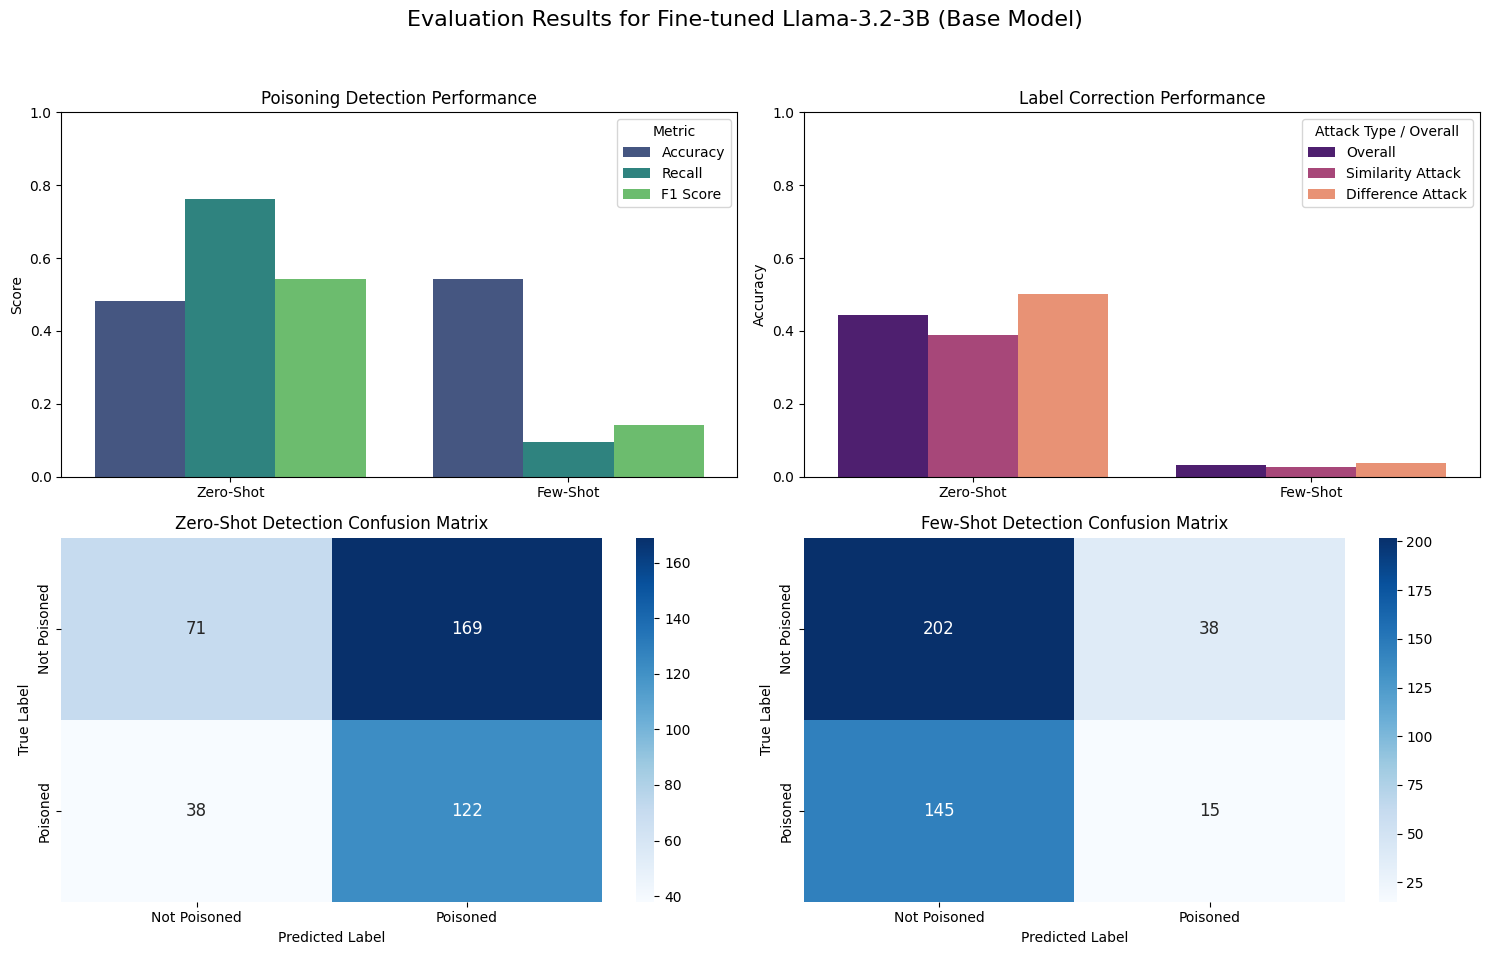

In [25]:
# Cell 16: Visualize the results for Base Model

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

# Set up the figure
plt.figure(figsize=(15, 10))
plt.suptitle('Evaluation Results for Fine-tuned Llama-3.2-3B (Base Model)', fontsize=16) # Overall title

# 1. Detection Performance
plt.subplot(2, 2, 1)
# Use the recalculated metrics
detection_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Accuracy': [evaluation_report['detection']['zero_shot']['accuracy'], evaluation_report['detection']['few_shot']['accuracy']],
    'Recall': [evaluation_report['detection']['zero_shot']['recall'], evaluation_report['detection']['few_shot']['recall']],
    'F1 Score': [evaluation_report['detection']['zero_shot']['f1_score'], evaluation_report['detection']['few_shot']['f1_score']]
}
detection_df = pd.DataFrame(detection_data)
detection_df_melted = pd.melt(detection_df, id_vars=['Method'], var_name='Metric', value_name='Score')
sns.barplot(x='Method', y='Score', hue='Metric', data=detection_df_melted, palette='viridis')
plt.title('Poisoning Detection Performance')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('') # Remove redundant label

# 2. Correction Performance
plt.subplot(2, 2, 2)
# Use the recalculated metrics, handling potential None values if attacks didn't exist
correction_data = {
    'Method': ['Zero-Shot', 'Few-Shot'],
    'Overall': [evaluation_report['correction']['zero_shot'].get('correction_accuracy', 0), evaluation_report['correction']['few_shot'].get('correction_accuracy', 0)],
    'Similarity Attack': [evaluation_report['correction']['zero_shot'].get('similarity_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('similarity_attack_accuracy', 0)],
    'Difference Attack': [evaluation_report['correction']['zero_shot'].get('difference_attack_accuracy', 0), evaluation_report['correction']['few_shot'].get('difference_attack_accuracy', 0)]
}
correction_df = pd.DataFrame(correction_data)
correction_df_melted = pd.melt(correction_df, id_vars=['Method'], var_name='Attack Type / Overall', value_name='Accuracy')
sns.barplot(x='Method', y='Accuracy', hue='Attack Type / Overall', data=correction_df_melted, palette='magma')
plt.title('Label Correction Performance')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('') # Remove redundant label

# 3. Confusion Matrix for Zero-Shot Detection
plt.subplot(2, 2, 3)
cm_zero = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_zero_shot_ft'])
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'],
            annot_kws={"size": 12}) # Adjust annotation size
plt.title('Zero-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 4. Confusion Matrix for Few-Shot Detection
plt.subplot(2, 2, 4)
cm_few = confusion_matrix(eval_df['is_poisoned'], eval_df['is_poisoned_few_shot_ft'])
sns.heatmap(cm_few, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Poisoned', 'Poisoned'],
            yticklabels=['Not Poisoned', 'Poisoned'],
            annot_kws={"size": 12}) # Adjust annotation size
plt.title('Few-Shot Detection Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
# Save the plot with the updated filename
PLOT_FILENAME_BASE = os.path.join(HOME, 'llama3.2-base_finetuned_evaluation.png')
plt.savefig(PLOT_FILENAME_BASE, dpi=300)
print(f"Evaluation plot saved to {PLOT_FILENAME_BASE}")
plt.show()
